# Toxic comment classification using LSTMs and pre-trained word-embeddings

Kaggle recently ran a toxic comment classification [challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). While I'm no ML expert, I tried my hand at attempting to make a decent submission.  

**Disclaimer:** This notebook describes my best effort which garnered a score of 0.9790 (private) and 0.9805 (public), which put me roughly at the 59th percentile. So make sure to look at things below from this lens. This is quite far from a top solution, but it did require me to explore a lot of new concepts, which prompted me to blog this notebook anyways.

### Topics covered in this notebook:
1. Pre-processing techniques for text data: tokenizing and limiting vocabulary.
1. Using pre-trained word-embeddings.
1. Using LSTM and CNN based models for comment classification.

## Pre-requisites

### Libraries setup
Getting all data-science related software setup correctly can be tricky. You can refer my [setup script](https://github.com/sumitgouthaman/workstation-setup) for details on my setup.

### Imports
We import all the libaries we need.

In [1]:
# Python 2 / 3 compatibility
from __future__ import print_function
from __future__ import division

from datetime import datetime
import io
import math
import os
import pickle
import random
import re
import string
import sys

from tqdm import tqdm  # To draw progress bars

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline  

# Keras
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.utils.data_utils import get_file 
from keras import backend as K

/home/sumit/Venv/mlpy3venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Peeking at the data
The dataset for the Kaggle challenge is available at https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data.

We load the train and test dataset as **Pandas** dataframes. We also have a sample submission file we can look at to ensure that the format of our output is correct.

To make it convenient later, we store the output class names in an array.

In [2]:
# Download dataset from https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
# Then
kaggle_train_dataset = pd.read_csv('train.csv')
kaggle_test_dataset = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

OUT_CLASSES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Let's look at the first few rows of the training data.

In [3]:
kaggle_train_dataset.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


And now first few rows of the Kaggle test data.

**Note:** We refer to the dataset used for evaluation by Kaggle as "Kaggle test data". This is to differentiate it from our "test data" that we siphon off from the Kaggle training data to validate how our training is going. We will only use the "Kaggle test data" towards the very end when we are ready to make a submission.

In [4]:
kaggle_test_dataset.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


**Observations:**
1. Each comment in the dataset has an id associated with it. This probably doesn't matter for the training data. But for submitting the final predictions on the Kaggle test data, we would need to write the id and the predictions in the output file.  
1. The Kaggle test data does not include the values for "toxic", "obscene", etc. Because we have to predict that.

Lets use the Pandas `describe` function to see stats about the dataframe columns.

In [5]:
kaggle_train_dataset.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Most of the rows above are useless for this type of data. But the "count" row shows that we have 1/0 values for all the columns in all the rows. In other words, we don't need to deal with missing data.

While we're at it, let's print out the sample submission to see what the expected output format is.

In [6]:
sample_submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


Let's shuffle the training dataset.  

We also separate the X and Y parts of the dataset. X contains the input (comments) and Y contains the 1/0 predictions for each of the output classes. `datasetX` and `datasetY` below are themselves Pandas dataframes and not numpy arrays.

In [7]:
kaggle_train_dataset = shuffle(kaggle_train_dataset)
datasetX_comments = kaggle_train_dataset[['comment_text']]
datasetY = kaggle_train_dataset[OUT_CLASSES]

As a sanity check, let's ensure that `datasetX_comments` contains the comments column from the dataset. 

In [8]:
datasetX_comments.head()

,comment_text
44725,Let me show you: 2 days ago the Executive Dir...
153197,"""\n :::Still the Golden Eagle is named as nati..."
157688,Dear 213.152.248.150: Please stop vandalizing...
123708,"I don't understand your rationale here, rather..."
75372,"On the other hand, copious Hoa escaped with th..."


Also, lets ensure that `datasetY`contains just the output prediction columns.

In [9]:
datasetY.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
44725,0,0,0,0,0,0
153197,0,0,0,0,0,0
157688,0,0,0,0,0,0
123708,0,0,0,0,0,0
75372,0,0,0,0,0,0


Since most frameworks like Keras and Tensorflow expect numpy arrays, let's convert the Pandas dataframes to numpy arrays using the `as_matrix` method.

In [10]:
datasetX_comments = datasetX_comments.as_matrix().reshape((-1))
datasetY = datasetY.as_matrix()

### Understanding stats about our input text
There are some relevant stats about our input comments that would be useful to know:  
1. What is the maximum length of any of the input comments?
1. How many unique words are in the dataset?
1. What does the frequency distribution of input words look like?

We can use the `text_to_word_sequence` function from Keras that makes it easy to split text into individual words. It is not possible to get this splitting exactly right because text typically can have tons of punctuations that can complicate determining where words start and end. The `text_to_word_sequence` function however takes care of ignoring common punctuation characters.

Let's do some processing to figure out the stats about our input data.

In [11]:
split_text = []
max_comment_word_len = 0
for c in datasetX_comments:
    split_c = text_to_word_sequence(c)
    max_comment_word_len = max(max_comment_word_len, len(split_c))
    split_text.extend(split_c)

unique_words_set = set(split_text)

word_counts = {}
for w in unique_words_set:
    word_counts[w] = 0
    
for w in split_text:
    word_counts[w] = word_counts[w] + 1

print('Max comment word length: %d' % max_comment_word_len)
print('Unique words: %d' % len(unique_words_set))

Max comment word length: 1403
Unique words: 210337


Let's plot the distribution of word frequencies.

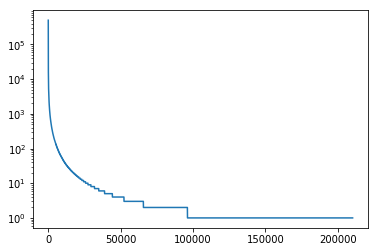

In [12]:
counts_arr = sorted(list(word_counts.values()), reverse=True)
plt.plot(counts_arr)
plt.yscale('log')
plt.show()

From that we see, there are more than 200K unique words. However, the long tail of words have very low frequencies. These are likely to be proper nouns.

To simplify our model, we can decide on a cut off and only consider words that have frequency higher than a certain cut off. From the plot above, somewhere between 30K and 50K seems like a good value for out vocabulary size. Eg. If we choose 40K as our Vocab zie, in our model, we will ignore words that have frequency lower than the 40K th most common word.

### Tokenizing
When dealing with text, it is typical to assign a unique integer id to each word in the corpus. This makes it simpler to represent the data as we feed it into a model.

Because this is such a common operation, Keras has built-in support for it. We need to **fit** the tokenizer object on our corpus so that it can assign a unique id to each word. We also initialize the tokenizer with a `num_words` parameter so that it knows how many of the top frequency words to take into account.

### Padding
Our model would expect each input row to be of the same dimension. This means once we decide on what the chosen input comment size is, we need to chop off some part of the input comments that are too long. We would also, need to **pad** the comments which are shorter.

Keras has built in support for this using the `pad_sequences` method.

Let's write a function that does both of these things.

In [13]:
def process_dataset(datasetX_comments, max_words, max_len):
    print ('Processing dataset, max_words: %d, max_length: %d' % (max_words, max_len))
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(datasetX_comments)

    datasetX_tokenized = tokenizer.texts_to_sequences(datasetX_comments)
    datasetX_padded = pad_sequences(datasetX_tokenized, maxlen=max_len)

    word_index = tokenizer.word_index
    print('Found %s unique tokens in dataset.' % len(word_index))
    
    return datasetX_padded, tokenizer

Lets execute this function with a vocab of 20K and max length of 14K words to do a sanity check of the output. The output is the tokenized, padded version of the input comments.

In [14]:
datasetX_padded, _ = process_dataset(datasetX_comments, 20000, 1400)
for i in range(2):
    print(datasetX_comments[i])
    print(datasetX_padded[i])
    print('-' * 50)
print('DatasetX padded shape:', datasetX_padded.shape)

Processing dataset, max_words: 20000, max_length: 1400
Found 210337 unique tokens in dataset.
Let me show you:  2 days ago the Executive Director of the State Bar admitted that the State Bar was involved in acts of serious public corruption and it was covered by most major news outlets ( https://www.google.com/#tbm=nws&q;=state+bar+california+dunn ).  Who better than to expose the corruption than the executive director of the Bar itself?  It's the Bar who has admitted this.  Knowing this information benefits you and is well-within Wikipedia's rules (it's already been added to other Encyclopedia's and Legal Journals).  Ask yourself why these accounts below keep deleting this information without the required discussion.  

Habitual Vandalizing of State Bar Article and Violations of 3 Revert Rule:
[  0   0   0 ... 231 360 656]
--------------------------------------------------
"
 :::Still the Golden Eagle is named as nationalcrest animal. It is not the crest animal, as you said the crest 

In [15]:
print('DatasetX padded shape:', datasetX_padded.shape)
datasetX_padded[:5]

DatasetX padded shape: (159571, 1400)


array([[    0,     0,     0, ...,   231,   360,   656],
       [    0,     0,     0, ...,   104,    16,   185],
       [    0,     0,     0, ...,    44,    16,   169],
       [    0,     0,     0, ...,  4879,    12,     6],
       [    0,     0,     0, ...,     3,     1, 12245]], dtype=int32)

## Evaluating a model

We need a metric to evaluate our model. From the Kaggle competition page, the predictions will be scored in a very specific way:

> Submissions are now evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.

Ideally, we would like to evaluate the performance of our model using the same metric. Let's implement a Keras callback that prints the above custom metric as evaluated on a given test set.

In [16]:
class CustomMetricsCallback(Callback):
    def __init__(self, testX, testY, freq=5):
        self.testX = testX
        self.testY = testY
        self.freq = freq

    def on_epoch_end(self, epoch, logs={}):
        if ((epoch+1) % self.freq != 0):
            return
        print('\n-- CUSTOM METRICS --')
        testY_pred = self.model.predict(self.testX, verbose=1, batch_size=256)
        roc_test = roc_auc_score(self.testY, testY_pred)
        print('roc-auc (test): %.5f' % roc_test)
        signifcant_actual = np.sum(np.any(self.testY > 0.5, axis=1))
        signifcant_preds = np.sum(np.any(testY_pred > 0.5, axis=1))
        print('Significant: %d (Actual) -- %d (Predictions)' % (signifcant_actual, signifcant_preds))
        print('-- CUSTOM METRICS END --')
        return

## Other callbacks

We would also like to print a sample of the predictions when the training ends. This serves a sanity check. For eg. we can verify that comments that are clearly toxic or obscene as marked as such.

In [17]:
class PrintSamples(Callback):
    def __init__(self, testX, testX_comment, testY):
        self.testX = testX
        self.testX_comment = testX_comment
        self.testY = testY

    def on_train_end(self, logs={}):
        testY_pred = self.model.predict(self.testX)
        print('-' * 10, 'Samples ()', '-' * 10)
        significant_example_idx = np.any(testY_pred >= 0.5, axis=1)
        significant_examples = self.testX_comment[significant_example_idx]
        significant_preds = testY_pred[significant_example_idx]
        significant_actual = self.testY[significant_example_idx]
        for i  in range(min(3, len(significant_examples))):
            print('Example: ', significant_examples[i])
            print('class\t\tActual\tPred')
            for ic, c in enumerate(OUT_CLASSES):
                print('%s\t\t%.3f\t%.3f' % (c, significant_actual[i][ic], significant_preds[i][ic]))
        return

Models involving text and LSTMs are very time consuming to train. We would like to checkpoint the model every few epochs.

Let's implement a helper method the returns a checkpointing callback for a given model.

In [18]:
def get_checkpoint_callback(model):
    dir_name = model.name
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)
    return ModelCheckpoint(
        dir_name + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        monitor='val_loss',
        period=1
    )

Finally, we implement a callback the would use the model to make predictions on the "Kaggle test dataset" and write the prediction to a file in the format Kaggle expects.

In [19]:
class KaggleOutputCallback(Callback):
    def __init__(self, tokenizer, kaggle_test_dataset, max_len, freq=5):
        self.tokenizer = tokenizer
        self.kaggle_test_dataset = kaggle_test_dataset
        self.max_len = max_len
        self.freq = freq
    
    def output(self, model, suffix=''):
        kaggle_testset_ids = self.kaggle_test_dataset[['id']].as_matrix().reshape((-1))
        kaggle_testset_comments = self.kaggle_test_dataset[['comment_text']].as_matrix().reshape((-1))

        kaggle_testX_tokenized = self.tokenizer.texts_to_sequences(kaggle_testset_comments)
        kaggle_testX_padded = pad_sequences(kaggle_testX_tokenized, maxlen=self.max_len)

        kaggle_testY_pred = model.predict(kaggle_testX_padded, verbose=1, batch_size=256)

        dir_name = model.name
        if not os.path.isdir(dir_name):
            os.makedirs(dir_name)
        
        fname = dir_name + '/output' + suffix + '.csv'
        with open(fname, 'w') as out:
            out.write('id,toxic,severe_toxic,obscene,threat,insult,identity_hate\n')
            for i, cid in enumerate(kaggle_testset_ids):
                out_line = '%s,%s\n' %(cid, ','.join(map(str, kaggle_testY_pred[i])))
                out.write(out_line)
        print('Wrote to file: ', fname)
    
    def on_epoch_end(self, epoch, logs={}):
        if ((epoch+1) % self.freq != 0):
            return
        self.output(self.model, '-' + str(epoch))
        return
    
    def on_train_end(self, logs={}):
        self.output(self.model, '-end')
        return

## Implementing the model

### Word embeddings
When it comes to models dealing with text data, word embeddings are a fantastic option.

There are others on the internet who have done a great job explaining work embeddings, so I
wont bother. Here's a few great videos: [[1]](https://www.youtube.com/watch?v=Eku_pbZ3-Mw), [[2]](https://www.youtube.com/watch?v=5PL0TmQhItY).

Here's the gist:
- When we represent each unique word in our corpus with an integer id, there is no relation between the ids assigned to similar words. Eg. The id for "King" and "Queen" would have no relation to each other.
- Instead, we use pre-trained word embeddings. These embeddings represent each word with a vector value. And these word vectors have interesting properties. For eg. If we subtract the vector for "Queen" from the vector for "King", we would get a vector that has very high cosine similarity to the vector formed by subtracting "Woman" from "Man".
- Using word vectors, our model can understand that "good job" and "great job" have similar meanings even if the actual input does not have "great job" anywhere.

#### Word embeddings in Keras
I did a simple Google search and found a good example of using pre-trainined embeddings in Keras: [[Link]](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

There are many options available when it comes to word embeddings: word2vec, Glove are names of pre-trained word embedding vectors that others have trained and made available.

Lets write a function that implements a Keras embedding layer for us given some parameters we care about. **Note:** this assumes that we have downloaded the Glove embedding values from http://nlp.stanford.edu/data/glove.6B.zip.

In [20]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')

def get_embedding_layer(tokenizer, embedding_dims, max_words, max_len, trainable=False):
    embeddings_index = {}
    with open(os.path.join(GLOVE_DIR, 'glove.6B.%dd.txt' % embedding_dims)) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Found %s word vectors.' % len(embeddings_index))

    # prepare embedding matrix
    word_index = tokenizer.word_index
    num_words = min(max_words, len(word_index))
    embedding_matrix = np.zeros((num_words, embedding_dims))
    for word, i in word_index.items():
        if i >= max_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = Embedding(num_words,
                                embedding_dims,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=trainable)  
    
    return embedding_layer

### Model definition
I tried many model architectures. Eventually, I arrived at one that gave me decent results. This is the only architecture I have included in this notebook.

This is a **multi-class, multi-label** classification problem. This means, for each input instance, multiple output classes could be possible at the same time. A comment could be both "toxic" and "obscene" at the same time.

Now I did some more research about multi-label classification. I found this blog post that was very helpful: [[Link]](https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/).

Few things to  keep in mind:  
1. We can arrange for the output size of our final fully-connected layer to be same as the number of output classes we are trying to predict.  
1. We should use the **"sigmoid"** activation instead of "softmax" activation we use in a classification problem. This is because in case of sigmoid, the value for  each class is independent of the others, while this is not the case for softmax.
1. We should use **"binary-crossentropy"** as the loss instead of "categorical_crossentropy" we typically use in a classification problem.

In [23]:
TEST_SPLIT = 0.05

EMBEDDING_DIM = 200  # 50 / 100 / 200 / 300
MAX_VOCAB_SIZE = 40000
MAX_SEQ_LENGTH = 1400

model_name_suffix = '-%d_dim_emb-%d_vocab' % (EMBEDDING_DIM, MAX_VOCAB_SIZE)

datasetX_padded, tokenizer = process_dataset(datasetX_comments, MAX_VOCAB_SIZE, MAX_SEQ_LENGTH)
embedding_layer = get_embedding_layer(tokenizer, EMBEDDING_DIM, MAX_VOCAB_SIZE, MAX_SEQ_LENGTH)

trainX_padded, testX_padded, trainY, testY, trainX_comment, testX_comment = train_test_split(
    datasetX_padded,
    datasetY,
    datasetX_comments,
    test_size=TEST_SPLIT)

sequence_input = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = Dropout(0.5)(x)
a = GlobalAveragePooling1D()(x)
m = GlobalMaxPooling1D()(x)
x = Concatenate()([a, m])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(6, activation='sigmoid')(x)

model = Model(sequence_input, preds, name='1_BiLstm_128-1_conv_128-Avg_Max_Pool-dense_128' + model_name_suffix)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(
    trainX_padded,
    trainY,
    validation_data=(testX_padded, testY),
    epochs=30,
    batch_size=128,
    callbacks = [
        CustomMetricsCallback(testX_padded, testY, freq=1),
        PrintSamples(testX_padded, testX_comment, testY),
        get_checkpoint_callback(model),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        KaggleOutputCallback(tokenizer, kaggle_test_dataset, MAX_SEQ_LENGTH, freq=1)
    ],
    shuffle=True,
)

Processing dataset, max_words: 40000, max_length: 1400
Found 210337 unique tokens in dataset.
Found 400000 word vectors.
Train on 151592 samples, validate on 7979 samples
Epoch 1/30
7979/7979 [==============================] - 14s 2ms/step
roc-auc (test): 0.97602
Significant: 775 (Actual) -- 638 (Predictions)
-- CUSTOM METRICS END --
153164/153164 [==============================] - 256s 2ms/step
Wrote to file:  1_BiLstm_128-1_conv_128-Avg_Max_Pool-dense_128-200_dim_emb-40000_vocab/output-0.csv
151592/151592 [==============================] - 2553s 17ms/step - loss: 0.0696 - acc: 0.9766 - val_loss: 0.0607 - val_acc: 0.9820
Epoch 2/30
7979/7979 [==============================] - 14s 2ms/step
roc-auc (test): 0.98058
Significant: 775 (Actual) -- 659 (Predictions)
-- CUSTOM METRICS END --
153164/153164 [==============================] - 256s 2ms/step
Wrote to file:  1_BiLstm_128-1_conv_128-Avg_Max_Pool-dense_128-200_dim_emb-40000_vocab/output-1.csv
151592/151592 [===========================

KeyboardInterrupt: 

## References

1. Toxic comment classification challenge on Kaggle: [[Link]](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).
1. Using pre-trained word embeddings in a Keras model: [[Link]](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).
1. Guide To Multi-Class Multi-Label Classification With Neural Networks In Python: [[Link]](https://www.depends-on-the-definition.com/guide-to-multi-label-classification-with-neural-networks/).